In [15]:
import sys
sys.path.append('/home/ahabis/2-Scribble_project')
from config import *
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from uncertainty_metrics import *
import pandas as pd
from PIL import Image

In [2]:
def metrics(predictions, trues):
    tp = np.sum((predictions) * trues)
    tn = np.sum((1 - predictions) * (1 - trues))
    fp = np.sum((predictions) * (1 - trues))
    fn = np.sum((1 - predictions) * trues)
    eps = 1e-6
    precision_healthy = tn / (tn + fn + eps)
    precision_tumor = tp / (tp + fp + eps)
    m_precision = (precision_healthy + precision_tumor) / 2
    recall_tumor = tp / (tp + fn + eps)

    recall_healthy = tn / (tn + fp + eps)
    m_recall = (recall_tumor + recall_healthy) / 2
    f1 = 2 * (m_precision * m_recall) / (m_precision + m_recall + eps)
    balanced_accuracy = (m_precision + m_recall) / 2
    
    return balanced_accuracy, m_precision, m_recall, f1

In [3]:
image_list = os.listdir(path_prediction_features)
normalized_stds = np.zeros(len(image_list))
normalized_entropies = np.zeros(len(image_list))
# normalized_binary_ratios = np.zeros(len(image_list))
images_f_scores = np.zeros(len(image_list))

for i, image in enumerate(image_list[:]):

    current_image_prediction_path = os.path.join(path_prediction_features, image, 'predictions.npy')
    current_image_trues_path = os.path.join(path_prediction_features, image, 'trues.npy')
    trues = np.load(current_image_trues_path)
    mc_predictions = np.squeeze(np.load(current_image_prediction_path))
    # print(mc_predictions.shape)
    # STDs
    normalized_stds[i] = compute_std(mc_predictions,
                                     patch_level=False,
                                     optimal_threshold=0.33)
    # Entropy
    normalized_entropies[i] = compute_entropy(mc_predictions,
                                              patch_level=False,
                                              optimal_threshold=0.33)
    # normalized_binary_ratios[i] = compute_minority_vote_ratio(mc_predictions, patch_level=False)
    #F1 Scores
    f1 = metrics(np.mean(mc_predictions,0),trues)[3]
    images_f_scores[i] = f1

_, _, r_value_entropy, _, _ = stats.linregress(normalized_entropies, images_f_scores)
_, _, r_value_stds, _, _ = stats.linregress(normalized_stds, images_f_scores)


/usr/local/lib/python3.8/dist-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


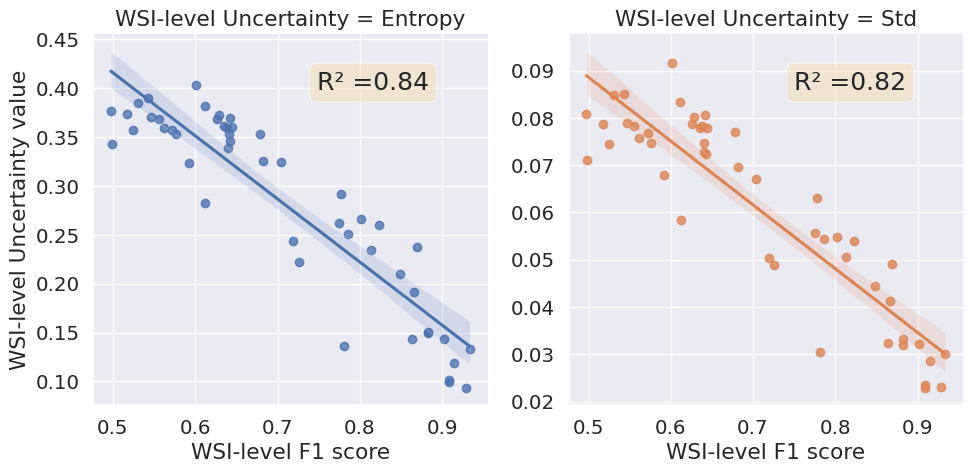

In [4]:
n = normalized_entropies.shape[0]
sns.set_theme()

sns.set(font_scale=1.3)

uncertainty_values = np.concatenate([normalized_entropies, normalized_stds])
uncertainty = np.concatenate([np.repeat("Entropy", n), np.repeat("Std", n)])
images_f_scores_fin = np.concatenate([images_f_scores, images_f_scores])
x = np.stack([uncertainty_values, images_f_scores_fin], axis=-1)

df = pd.DataFrame(x, columns=["WSI-level Uncertainty value", "WSI-level F1 score"])
df["WSI-level Uncertainty"] = uncertainty

sns.lmplot(
    data=df,
    x="WSI-level F1 score",
    y="WSI-level Uncertainty value",
    hue="WSI-level Uncertainty",
    col="WSI-level Uncertainty",
    sharey=False,
    facet_kws=dict(sharex=False, sharey=False),
)
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

plt.text(
    0.17,
    0.09,
    "R² ={}".format(np.round(r_value_entropy**2, 2)),
    fontsize=18,
    verticalalignment="top",
    bbox=props,
)

plt.text(
    0.75,
    0.09,
    "R² ={}".format(np.round(r_value_stds**2, 2)),
    fontsize=18,
    verticalalignment="top",
    bbox=props,
)

# plt.grid()
# seaborn.set_style('ticks')
import matplotlib

matplotlib.rc("xtick", labelsize=5)
matplotlib.rc("ytick", labelsize=5)
plt.show()